In [18]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

In [19]:
#read dataset
original_dms_data = pd.read_csv('/Users/liza/Documents/Bioinfo Project/DMS_data/AAAA_GFP_dms_data_original_komplett.csv')
# split first column of df into multiple columns
original_dms_data_col = original_dms_data
only_mutants = original_dms_data["mutant"].to_frame()
original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/3558580236.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)


PREPARE DATASET FOR RANKING CALCULATION:
1. how many mutations does each mutant have? -> mut_count (df_mutation_count)
2. find out all possible mutations -> all_possible_mutations
3. df mutations x mutants -> which mutants contain which mutations -> result_how_often
4. plots + calculation variance x how many values used for variance per mutation count
-> variance of all fscores of all mutants containing mutation X shows how constant the effect of the mutation is


In [20]:
# count how many mutations each mutant has
list_mut_count_in_progress = []
for i in range(len(original_dms_data['mutant'])):
    list_mut_count_in_progress.append(original_dms_data['mutant'].iloc[i].count(':'))
list_mut_count_prae = np.array(list_mut_count_in_progress)
list_mut_count = (list_mut_count_prae + 1)
df_mutation_counts = pd.DataFrame(list_mut_count)

In [21]:
#concat mutation_count to original df
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")

working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)
working_dataframe.head()

,DMS_score,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,mut_count
0,1.301030,K3R,V55A,Q94R,A110T,D117G,M153K,D216A,None,None,None,None,None,None,None,None,7
1,3.137350,K3Q,V16A,I167T,L195Q,None,None,None,None,None,None,None,None,None,None,None,4
2,1.553913,K3Q,Y143C,N164D,S205P,A227T,None,None,None,None,None,None,None,None,None,None,5
3,3.404237,K3Q,Y143N,V193A,None,None,None,None,None,None,None,None,None,None,None,None,3
4,3.738586,K3R,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1


In [22]:
#all existing mutations in one list: calculation of all_possible_mutations

working_dataframe_only_ms = working_dataframe.loc[:, ["m1", "m2", "m3", 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']]
all_possible_mutations = working_dataframe_only_ms.values.flatten().tolist()
all_possible_mutations = list(set(all_possible_mutations))
#"none" is also a value in the list -> remove
while None in all_possible_mutations:
    all_possible_mutations.remove(None)
only_mutants_list = only_mutants['mutant']


In [23]:
#remodel df so it is more convenient
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")
working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)


In [24]:
#df which mutant from only_mutants_list contains the mutations from all_possible_mutations
list_of_dfs = []


for i in all_possible_mutations:
    new_column_name = f'{i}'
    new_column_values = [only_mutants_list.str.contains(i, regex= False)]
    new_df = pd.DataFrame({new_column_name: new_column_values})
    new_df_exploded = new_df.explode(new_column_name)
    list_of_dfs.append(new_df_exploded)

# concat dfs from the list
result_how_often = pd.concat(list_of_dfs, axis=1)
result_how_often = result_how_often.reset_index(drop=True)

## result_how_often.to_csv('dataframe_mutanten_Mutationen.csv', index=True)

In [25]:
# more convenient df (just mutcount und fscore)
count_fscore_frame = working_dataframe[['DMS_score', 'mut_count']]

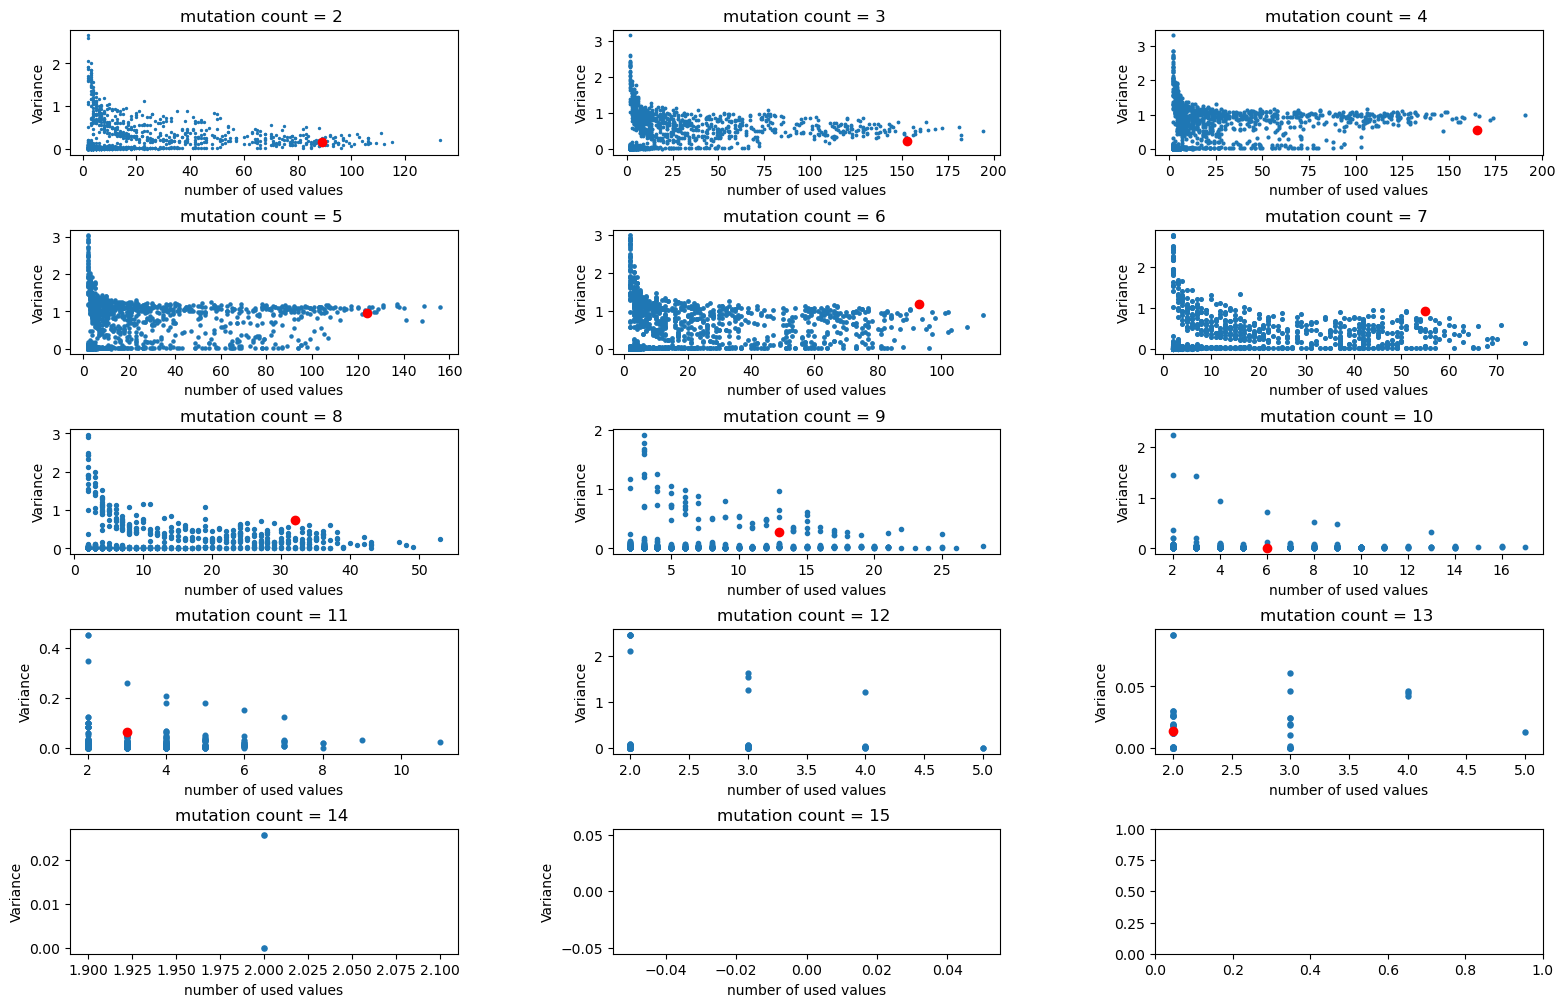

In [26]:
#plot: variance of fscores per mutation count and number of values uesed for variance calculation
#-> bottom right corner is the best, because the varaince is the most reliable

import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(19, 12))  # Abbildung und Achsenobjekte erstellen
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for j, ax in zip(range(2, 16), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()
        variance_per_mutant_list.append(varianz_mut)

    variance_per_mutant_series = pd.Series(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_df = variance_per_mutant_series.to_frame()


#how reliable is the calculated variance? -> how many values are available for the calculation

    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_for_variance = pd.Series(how_many_for_variance, index=all_possible_mutations)
    how_many_for_variance_df = how_many_for_variance.to_frame()


    how_many_AND_variance_df = pd.concat([how_many_for_variance_df, variance_per_mutant_df], axis = 1)
    how_many_AND_variance_df.columns = ['number of used values', 'Variance']
    how_many_AND_variance_df = how_many_AND_variance_df.dropna()

#scatter plot variance x count
    ax.scatter(how_many_AND_variance_df['number of used values'],how_many_AND_variance_df['Variance'], s = j )
    ax.set_xlabel('number of used values')
    ax.set_ylabel('Variance')

    if "V163A" in how_many_AND_variance_df.index:
        ax.scatter(how_many_AND_variance_df['number of used values']['V163A'],how_many_AND_variance_df['Variance']['V163A'], c='red')
    ax.set_title(f'mutation count = {j} ')



FURTHER PREPARATION FOR RANKINGS:
1. variance calculation per mutant (not-weighted)
2. how many values got used for the calculation, same as above but for every mutcount combined
-> both in one dataframe
3. calculate df that contains the difference between the fscore-means of all mutants WITH mutation X and WITHOUT mutation X
-> how big is the effect of the mutation on existing in general
-> not weighted

In [27]:
#variance means, calculate variances per mutation per mutation count -> mean of all per mutation
#ONLY MUTCOUNT FROM 2 TO 7 !! -> 5a
#-> not yet weighted

frame_zum_mitteln_variance = pd.DataFrame(index = all_possible_mutations)
variance_per_mutant_count_list = []

# IMPORTANT!! -> only values from mutants with up to 7 mutations (mut_count < 7), because the fscores from mutants with a mut_counts above 7 are generally low (-> boxplot from statistical_test_fscores)
for j, ax in zip(range(2, 8), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()  #die varianz je mutation je anzahl
        variance_per_mutant_list.append(varianz_mut) #liste der Varianzen ALLER Mutationen je anzahl

    variance_per_mutant_df = pd.DataFrame(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_count_list.append(variance_per_mutant_df)
variance_per_mutant_count_df = pd.concat(variance_per_mutant_count_list, axis=1)
variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

# df variance per mutatuion (rows) per mutation_count (columns)
variance_per_mutant_count_df
mean_variances_per_mutations = pd.DataFrame(variance_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/404395272.py:21: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [28]:
#variance means, calculate variances per mutation per mutation count -> mean of all per mutation
#ALL MUTCOUNTS INVOLVED -> 5c
#-> not yet weighted
frame_zum_mitteln_variance_16 = pd.DataFrame(index=all_possible_mutations)
variance_per_mutant_count_list_16 = []

#
# da die Fitness-Scores von Mutanten mit einer mut_count über 7 im Allgemeinen niedrig sind.
for j in range(2, 16):
    variance_per_mutant_list_16 = []

    for i in all_possible_mutations:
        mut_count_fscore_16 = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut_16 = mut_count_fscore_16['DMS_score'].loc[mut_count_fscore_16['mut_count'] == j]
        varianz_mut_16 = fscore_mut_16.var()  # Varianz für die aktuelle Mutation und Mutation_count
        variance_per_mutant_list_16.append(varianz_mut_16)

    variance_per_mutant_df_16 = pd.DataFrame(variance_per_mutant_list_16, index=all_possible_mutations)
    variance_per_mutant_count_list_16.append(variance_per_mutant_df_16)

variance_per_mutant_count_df_16 = pd.concat(variance_per_mutant_count_list_16, axis=1)
variance_per_mutant_count_df_16.columns = range(2, 16)

mean_variances_per_mutations_16 = pd.DataFrame(variance_per_mutant_count_df_16.mean(axis=1, skipna=True), columns=['Mean'])


In [29]:
#goal: weights for weighted variance in ranking 5d
#variance gets weighted with how many values excist for calculation
how_many_per_mutant_count_list = []

for j, ax in zip(range(2, 16), axes.flatten()):
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_per_mutant_df = pd.DataFrame(how_many_for_variance, index=all_possible_mutations)
    how_many_per_mutant_count_list.append(how_many_per_mutant_df)
how_many_per_mutant_count_df = pd.concat(how_many_per_mutant_count_list, axis=1)
how_many_per_mutant_count_df.set_axis(range(2,16), axis=1, inplace=True)

mean_how_many_per_mutations = pd.DataFrame(how_many_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/3006918786.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  how_many_per_mutant_count_df.set_axis(range(2,16), axis=1, inplace=True)


In [30]:
combined_means_variance_how_many = pd.concat([mean_variances_per_mutations, mean_how_many_per_mutations], axis=1)
combined_means_variance_how_many.columns = ['mean_variances_per_mutations', 'mean_how_many_per_mutations']

In [31]:
#differences calculated (effect of mutation X on the fscore)
nur_fscore_mut_count = working_dataframe.loc[:, ["DMS_score", "mut_count"]]
differences_list = []

for i in all_possible_mutations:
    #for all mutants WITH the mutation
    #filter the mutants for the existing of mutation X (-> result_how_often)
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index
    #fscores from all mutants that match
    only_rows_with_mut = nur_fscore_mut_count [(nur_fscore_mut_count ['mut_count'] >2) & (nur_fscore_mut_count .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_only_mut = only_rows_with_mut['DMS_score'].mean()
#-------------
    #for all mutants WITHOUT the mutation (same calculation)
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = working_dataframe[(working_dataframe['mut_count'] >2) & (working_dataframe.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_every_but_mut = only_rows_withOUT_mut['DMS_score'].mean()
#----------------
    difference_means = mean_dms_score_only_mut - mean_dms_score_every_but_mut
    differences_list.append(difference_means)

all_differences_means = pd.DataFrame({'Difference': differences_list}, index=all_possible_mutations)


----------------RANKING 0:
-> ranked by variance (without taking into account how many values got used for the calculation)

In [32]:
sorted_Ranking0 = combined_means_variance_how_many.sort_values(by='mean_variances_per_mutations')

sorted_Ranking0

,mean_variances_per_mutations,mean_how_many_per_mutations
Y66S,1.264636e-14,0.642857
M233S,7.899120e-14,0.214286
A110P,8.391788e-14,0.428571
A206P,1.307599e-13,0.357143
F100P,1.963388e-13,0.357143
...,...,...
N159R,NaN,0.071429
K85L,NaN,0.071429
I152M,NaN,0.071429
S147D,NaN,0.071429


In [33]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking0= sorted_Ranking0.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking0.html', 'w') as file:
    file.write(styled_ranking0.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/428012128.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking0.render())


----------------RANKING 1: (that was the try if the ranking-function works)
-> ranked by the available values for each mutation (how often does mutation X appear in total)

In [34]:
sorted_Ranking1 = combined_means_variance_how_many.sort_values(by='mean_how_many_per_mutations', ascending= False)

print(sorted_Ranking1)

       mean_variances_per_mutations  mean_how_many_per_mutations
N121S                      0.711986                    67.857143
K214E                      0.651496                    59.857143
K113R                      0.690536                    59.214286
N164S                      0.681112                    59.214286
F8L                        0.589693                    59.071429
...                             ...                          ...
V11K                            NaN                     0.000000
N144A                           NaN                     0.000000
K158V                           NaN                     0.000000
E6R                             NaN                     0.000000
K209S                           NaN                     0.000000

[1810 rows x 2 columns]


In [35]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking1= sorted_Ranking1.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking1.html', 'w') as file:
    file.write(styled_ranking1.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/4056409736.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking1.render())






----------------RANKING 1a:
-> ranked by a rank_score build from the variance and the count of available mutations
-> combination of ranking 0 and 1

In [36]:
combined_means_variance_how_many['Rank'] = combined_means_variance_how_many['mean_variances_per_mutations'].rank(ascending=False) - combined_means_variance_how_many['mean_how_many_per_mutations'].rank()

sorted_Ranking1a = combined_means_variance_how_many.sort_values(by='Rank')

print(sorted_Ranking1a)

       mean_variances_per_mutations  mean_how_many_per_mutations    Rank
K107R                      0.796342                    44.142857 -1545.0
D190G                      0.791333                    41.642857 -1522.5
D117G                      0.761510                    46.857143 -1515.0
N164D                      0.750293                    48.928571 -1506.0
K101R                      0.760502                    41.785714 -1484.5
...                             ...                          ...     ...
N159R                           NaN                     0.071429     NaN
K85L                            NaN                     0.071429     NaN
I152M                           NaN                     0.071429     NaN
S147D                           NaN                     0.071429     NaN
F165H                           NaN                     0.142857     NaN

[1810 rows x 3 columns]


In [37]:
#same ranking just with only the stabilizing (Difference > 0)
condition = all_differences_means['Difference'] > 0
sorted_only_stab_Ranking1a = sorted_Ranking1a.drop(all_differences_means.loc[condition].index)
print(sorted_only_stab_Ranking1a)


       mean_variances_per_mutations  mean_how_many_per_mutations    Rank
T225A                      0.721625                    46.142857 -1428.5
N185S                      0.713168                    49.357143 -1428.0
N149S                      0.708680                    41.785714 -1379.5
M88L                       0.790748                    24.214286 -1371.0
K209R                      0.684093                    47.000000 -1351.0
...                             ...                          ...     ...
Y39T                            NaN                     0.071429     NaN
K166D                           NaN                     0.071429     NaN
K85L                            NaN                     0.071429     NaN
S147D                           NaN                     0.071429     NaN
F165H                           NaN                     0.142857     NaN

[1136 rows x 3 columns]


In [38]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking1a= sorted_only_stab_Ranking1a.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking1a.html', 'w') as file:
    file.write(styled_ranking1a.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/3618736848.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking1a.render())






----------------RANKING 2:
-> only ranked by Difference
-> how big is the effect the mutation has on other excisting mutations (->fscores)

In [39]:
#how often does the mutation X appear in all mutants
list_wie_oft_mut = []
for j in all_possible_mutations:
    matching_indexes = result_how_often.loc[result_how_often[j] == True].index
    wie_oft = len(matching_indexes)
    list_wie_oft_mut.append(wie_oft)
df_wie_oft_muts_insg = pd.DataFrame(list_wie_oft_mut, index=all_possible_mutations)
df_wie_oft_muts_insg

,0
R168L,24
L7V,11
P75F,1
I14N,120
S205A,35
...,...
D19E,37
Q177L,354
G232S,110
P89S,61


In [40]:
#difference and count in one dataframe
combined_differenz_wie_oft_mut= pd.concat([all_differences_means, df_wie_oft_muts_insg], axis=1)
combined_differenz_wie_oft_mut.columns = ['Difference', 'wie oft kommt mut insg vor']


In [41]:
ranking2 = combined_differenz_wie_oft_mut.sort_values(by='Difference', ascending= False)
ranking2

,Difference,wie oft kommt mut insg vor
E17W,1.444187,1
N23C,1.428999,1
L207V,1.389604,3
T43V,1.384775,1
T118R,1.359756,1
...,...,...
F99N,NaN,1
D21S,NaN,1
K101L,NaN,1
N159V,NaN,2


In [42]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking2= ranking2.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking2.html', 'w') as file:
    file.write(styled_ranking2.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/1800979359.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking2.render())






----------------RANKING 3:
-> ranked by difference and count


In [43]:
list_ranking3 = []
for i in all_possible_mutations:
    score_ranking3 = all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]
    list_ranking3.append(score_ranking3)
ranking3_unsorted = pd.DataFrame(list_ranking3, index=all_possible_mutations, columns=['ranking3_score'])
ranking3 = ranking3_unsorted.sort_values(by='ranking3_score', ascending= False)
print(ranking3)

       ranking3_score
V163A      388.828780
I171V      257.867360
S175G      219.571456
K113R      216.440643
I167V      212.858116
...               ...
F99N              NaN
D21S              NaN
K101L             NaN
N159V             NaN
T43C              NaN

[1810 rows x 1 columns]


In [44]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking3= ranking3.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking3.html', 'w') as file:
    file.write(styled_ranking3.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/830632918.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking3.render())






----------------RANKING 4:
-> calculate own score1
-> score1 = Difference * 1/Variance * Anzahl muts
-> score1 = "effect of the mutation" * 1/"how reliable is the mean_fscore" * how much data is available
-> Variance here: just the mean of all variances per mutcount per muatation (mutcount 2 to 7)

In [45]:
list_ranking4 = []
for i in all_possible_mutations:
    score_ranking4 = all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]*(1/mean_variances_per_mutations.loc[i].values[0])
    list_ranking4.append(score_ranking4)
ranking4_unsorted = pd.DataFrame(list_ranking4, index=all_possible_mutations, columns=['ranking4_score'])
ranking4 = ranking4_unsorted.sort_values(by='ranking4_score', ascending= False)
ranking4

,ranking4_score
E5R,17041.430971
N164C,10896.792112
I128M,2541.597661
E142Q,2120.278517
G232R,723.050574
...,...
N159R,NaN
K85L,NaN
I152M,NaN
S147D,NaN


In [46]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking4= ranking4.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking4.html', 'w') as file:
    file.write(styled_ranking4.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/652468287.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking4.render())






----------------RANKING 5:
-> calculate own score, just like ranking 4 just different kind of variances
-> score2 = Difference * 1/Variance


In [47]:
#PREP for 5b: variances weighted with mean_fitness_scores as weights
#dataframe with the mean fscores of each mutation count
mean_fitness_scores = pd.DataFrame(index = range(2,16), columns = ["mean_fitness_score"])
for i in range(2,16):
    fscore_mutcount_mean = count_fscore_frame["DMS_score"].loc[count_fscore_frame["mut_count"] == i].mean()
    mean_fitness_scores.loc[i, "mean_fitness_score"] = fscore_mutcount_mean

weighted_variances_try = pd.Series(index=variance_per_mutant_count_df_16.index)

for mutation in all_possible_mutations:
    row_variance = variance_per_mutant_count_df_16.loc[mutation]
    non_nan_values_variance = row_variance.dropna()

    if len(non_nan_values_variance) > 0:
        non_nan_weights_variance = mean_fitness_scores.loc[non_nan_values_variance.index]['mean_fitness_score']
        weighted_variances_try[mutation] = np.average(non_nan_values_variance, weights=non_nan_weights_variance)

weighted_variances_try_df = pd.DataFrame({'Weighted Variances': weighted_variances_try})


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/1871570162.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weighted_variances_try = pd.Series(index=variance_per_mutant_count_df_16.index)


In [48]:
#PREP for 5d: variances weighted with wieviel as weights
#dataframe with the mean fscores of each mutation count

for mutation in all_possible_mutations:
    row_variance = variance_per_mutant_count_df_16.loc[mutation]
    non_nan_values_variance = row_variance.dropna()
    row_weight_how_many = how_many_per_mutant_count_df.loc[mutation].to_frame(name = 'how_many')

    if len(non_nan_values_variance) > 0:
        non_nan_weights_variance = row_weight_how_many.loc[non_nan_values_variance.index]['how_many']
        weighted_variances_try[mutation] = np.average(non_nan_values_variance, weights=non_nan_weights_variance)

weighted_variances_d_df = pd.DataFrame({'Weighted Variances': weighted_variances_try})


In [49]:
#ranking5_0: wrong calculation of the variance (only the mutations that have complete data for all mutcounts
#not mean of variance but sum! -> how "complete" is dataset

list_ranking5_0 = []
for i in all_possible_mutations:

    score_ranking5_0 =score_ranking5_0 = (all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]) / np.nansum(variance_per_mutant_count_df.loc[i].values)

    list_ranking5_0.append(score_ranking5_0)
ranking5_0_unsorted = pd.DataFrame(list_ranking5_0, index=all_possible_mutations, columns=['ranking5_0_score'])
ranking5_0 = ranking5_0_unsorted.sort_values(by='ranking5_0_score', ascending= False)
ranking5_0

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/541668923.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  score_ranking5_0 =score_ranking5_0 = (all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]) / np.nansum(variance_per_mutant_count_df.loc[i].values)


,ranking5_0_score
Q157W,inf
K113L,inf
K214I,inf
H169C,inf
E17M,inf
...,...
F99N,NaN
D21S,NaN
K101L,NaN
N159V,NaN


In [50]:
#variance calculated with the mean over all mut count varaiances
list_ranking5_a = []
for i in all_possible_mutations:
    score_ranking5_a = (all_differences_means.loc[i].values[0]) * df_wie_oft_muts_insg.loc[i].values[0] / (mean_variances_per_mutations_16.loc[i].values[0])
    list_ranking5_a.append(score_ranking5_a)
ranking5_unsorted_a = pd.DataFrame(list_ranking5_a, index=all_possible_mutations, columns=['ranking5_a_score'])
ranking5_a = ranking5_unsorted_a.sort_values(by='ranking5_a_score', ascending= False)
ranking5_a


,ranking5_a_score
E5R,17041.430971
N164C,10896.792112
I128M,2541.597661
E142Q,2120.278517
V163A,830.480948
...,...
N159R,NaN
K85L,NaN
I152M,NaN
S147D,NaN


In [51]:
#variance calculated with the mean fscores of the corresponding mutcount group
list_ranking5_b = []
for i in all_possible_mutations:

    score_ranking5_b = (all_differences_means.loc[i].values[0]) * df_wie_oft_muts_insg.loc[i].values[0] / (weighted_variances_try_df.loc[i].values[0])
    list_ranking5_b.append(score_ranking5_b)
ranking5_unsorted_b = pd.DataFrame(list_ranking5_b, index=all_possible_mutations, columns=['ranking5_b_score'])
ranking5_b = ranking5_unsorted_b.sort_values(by='ranking5_b_score', ascending= False)
ranking5_b


,ranking5_b_score
E5R,17041.430971
N164C,10896.792112
I128M,2541.597661
E142Q,2120.278517
V163A,842.294435
...,...
N159R,NaN
K85L,NaN
I152M,NaN
S147D,NaN


In [52]:
#variance mean from the variances from the mutcount groups 2 to 7
list_ranking5_c = []
for i in all_possible_mutations:

    score_ranking5_c = (all_differences_means.loc[i].values[0]) * df_wie_oft_muts_insg.loc[i].values[0] / (mean_variances_per_mutations.loc[i].values[0])
    list_ranking5_c.append(score_ranking5_c)
ranking5_unsorted_c = pd.DataFrame(list_ranking5_c, index=all_possible_mutations, columns=['ranking5_c_score'])
ranking5_c = ranking5_unsorted_c.sort_values(by='ranking5_c_score', ascending= False)
ranking5_c


,ranking5_c_score
E5R,17041.430971
N164C,10896.792112
I128M,2541.597661
E142Q,2120.278517
G232R,723.050574
...,...
N159R,NaN
K85L,NaN
I152M,NaN
S147D,NaN


In [53]:
#variance mean weighted with how many values there are for each group
list_ranking5_d = []
for i in all_possible_mutations:

    score_ranking5_d = (all_differences_means.loc[i].values[0]) * df_wie_oft_muts_insg.loc[i].values[0] / (mean_variances_per_mutations.loc[i].values[0])
    list_ranking5_d.append(score_ranking5_d)
ranking5_unsorted_d = pd.DataFrame(list_ranking5_d, index=all_possible_mutations, columns=['ranking5_d_score'])
ranking5_d = ranking5_unsorted_d.sort_values(by='ranking5_d_score', ascending= False)
ranking5_d


,ranking5_d_score
E5R,17041.430971
N164C,10896.792112
I128M,2541.597661
E142Q,2120.278517
G232R,723.050574
...,...
N159R,NaN
K85L,NaN
I152M,NaN
S147D,NaN


In [57]:
#code for formatting: change name to us
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking5_d= ranking5_d.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking5_d.html', 'w') as file:
    file.write(styled_ranking5_d.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/924459968.py:12: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5_d.render())







RANKING 6:
-> delta G values ranked on their own
-> but calculated as differences as fscores

In [58]:
delta_G_data = pd.read_csv('/Users/liza/Downloads/df_ddG.csv')

In [59]:
count_fscore_frame['delta G'] = delta_G_data['Score']
print(count_fscore_frame)

       DMS_score  mut_count       delta G
0       1.301030          7  73620.483101
1       3.137350          4  72519.649577
2       1.553913          5  72506.131486
3       3.404237          3  72360.943228
4       3.738586          1  72850.815804
...          ...        ...           ...
51709   3.809468          1  74392.873843
51710   3.760217          1  74293.271125
51711   3.754101          1  74347.569818
51712   3.673173          1  74517.866311
51713   3.735417          1  74420.070261

[51714 rows x 3 columns]


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/2383831306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_fscore_frame['delta G'] = delta_G_data['Score']


In [60]:
#same calculation as for the fscores above to get the general impact of one mutation on the delta G values
differences_delta_G_list = []

for i in all_possible_mutations:
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index

    only_rows_with_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_only_mut = only_rows_with_mut['delta G'].mean()
#-------------
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_every_but_mut = only_rows_withOUT_mut['delta G'].mean()
#----------------
    difference_means_delta_G = mean_delta_G_every_but_mut - mean_delta_G_only_mut
    differences_delta_G_list.append(difference_means_delta_G)

all_differences_delta_G_means = pd.DataFrame({'Difference dG': differences_delta_G_list}, index=all_possible_mutations)

# the better the stability of the mutation
#-> difference: WITHOUT - WITH, better mutations have higher difference scores

In [61]:
#ranking delta G
combined_difference_dG_wie_oft_mut = pd.concat([all_differences_delta_G_means, df_wie_oft_muts_insg], axis=1)
combined_difference_dG_wie_oft_mut.columns = ['Difference dG', 'wie oft kommt mut insg vor']

ranking6 = combined_difference_dG_wie_oft_mut.sort_values(by='Difference dG', ascending=False)

ranking6 = ranking6.drop(ranking6[~(ranking6['wie oft kommt mut insg vor'] >= 20)].index)

print(ranking6)

       Difference dG  wie oft kommt mut insg vor
R73C     1413.045266                         135
R73H     1364.227566                         122
M78T     1211.523327                         391
R73S     1162.357590                          30
R96S     1157.612694                          21
...              ...                         ...
G138R   -1270.588675                          91
H139R   -1289.981672                         561
H217R   -1401.940816                         336
S208R   -1426.174296                          33
C70R    -1511.372625                         340

[1013 rows x 2 columns]


In [62]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking6= ranking6.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking6.html', 'w') as file:
    file.write(styled_ranking6.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/1235763459.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking6.render())





RANKING 7:
-> delta G differences combined with ranking 5b (weighted variances with fscore_means)

In [63]:
list_ranking7 = []
for i in all_possible_mutations:

    score_ranking7 = (all_differences_means.loc[i].values[0]) * df_wie_oft_muts_insg.loc[i].values[0] * all_differences_delta_G_means.loc[i].values[0] / (weighted_variances_try_df.loc[i].values[0] )
    list_ranking7.append(score_ranking7)
ranking7_unsorted = pd.DataFrame(list_ranking7, index=all_possible_mutations, columns=['ranking7_score'])
ranking7 = ranking7_unsorted.sort_values(by='ranking7_score', ascending= False)
ranking7

,ranking7_score
A110P,2.267316e+16
A206P,1.920629e+16
F100P,3.371979e+15
I98A,8.524385e+14
N164V,3.770284e+10
...,...
N159R,NaN
K85L,NaN
I152M,NaN
S147D,NaN


In [64]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking7= ranking7.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking7.html', 'w') as file:
    file.write(styled_ranking7.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_19316/3981476843.py:11: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking7.render())






-----------WEIGHTED RANKINGS
-> Differences gewichtet berechnen


In [66]:
# Create an empty DataFrame to store the results
mean_for_differences_withOUT_neu = pd.DataFrame(index=all_possible_mutations, columns=range(2, 16))

# Pre-calculate the row indices where mutation is not present in the mutants
index_when_mut_NOT_present_weighted = result_how_often[~result_how_often.any(axis=1)].index

# Filter nur_fscore_mut_count DataFrame to include only relevant rows
only_rows_withOUT_mut_weighted = nur_fscore_mut_count[nur_fscore_mut_count['mut_count'].isin(range(2, 16)) & nur_fscore_mut_count.index.isin(index_when_mut_NOT_present_weighted)]

# Group the filtered DataFrame by 'mutation' and 'mut_count' columns and calculate the mean of 'DMS_score'
mean_fitness_withOUT_mut_score = only_rows_withOUT_mut_weighted.groupby(['mutation', 'mut_count'])['DMS_score'].mean()

# Reshape the result DataFrame by unstacking the 'mut_count' column and setting mutations as row indices
mean_fitness_withOUT_mut_score = mean_fitness_withOUT_mut_score.unstack('mut_count')

# Assign the reshaped DataFrame to mean_for_differences_withOUT_neu
mean_for_differences_withOUT_neu = mean_fitness_withOUT_mut_score

# Optionally, you can rename the columns if desired
mean_for_differences_withOUT_neu.columns.name = 'mut_count'


KeyError: 'mutation'